# ATSC 500 Final Project - CALIPSO File Access and Retrieval

## Introduction

Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observations (CALIPSO) is an earth/environmental observation satellite which carries a high resolution lidar under the Cloud-Aerosol Lidar with Orthogonal Polarization (CALIOP) program. The CALIPSO lidar provides high-resolution vertical profiles of aerosols and clouds.

This notebook explains the file access, pre-processing and retrieval of Convective Boundary Layer (CBL) height through CALIPSO Lidar L1B Total Attenuated Backscatter product on the 532-nm channel 

## Data access

The CALIPSO L1B data is archived on [NASA Langley Research Center (LARC)](https://eosweb.larc.nasa.gov/project/calipso/cal_lid_l1-standard-v4-10) with an [HTML order tool](https://eosweb.larc.nasa.gov/HORDERBIN/HTML_Start.cgi?project=CALIPSO). After ordering, the registered LARC account will be assigned a time limited FTP access to the data. Based on the filesize and study time period, the file from November 2015 to February 2016 was downloaded and processed.

Based on the [Quality Summary](https://eosweb.larc.nasa.gov/PRODOCS/calipso/Quality_Summaries/CALIOP_L1ProfileProducts_3.01.html), the following variables are selected:

* **Profile_UTC_Time**: UTC time: yymmdd.ffffffff, f means the fraction of the day.
* **Surface_Elevation**: surface elevation above sea level at the laser footprint, obtained from the GTOPO30.
* **Tropopause_Height**: Tropopause height based on GMAO profiles.
* **Longitude, Latitude**: lat/lon coordinates from the laser footprint
* **Total_Attenuated_Backscatter_532**: the product of the 532-nm backscatter coefficient and the two-way optical transmission at 532-nm channel.

The vertical resolution of the lidar profile is listed as follows:

| Altitude Range [km] | Bin Number | Horizontal Resolution | Vertical Resolution [m] | Altitude Region |
| ------------------- | ---------- | --------------------- | ----------------------- | --------------- |
| 30.1 to 40.0        | 1-33       | 5                     | 300                     | 5               |
| 20.2 to 30.1        | 34-88      | 5/3                   | 180                     | 4               |
| 8.3 to 20.2         | 89-288     | 1                     | 60                      | 3               |
| -0.5 to 8.3         | 289-578    | 1/3                   | 30                      | 2               |
| -2.0 to -0.5        | 579-583    | 1/3                   | 300                     | 1               |

In [1]:
from sys import path
path.insert(0, '_libs/')

## Pre-processing 

In [2]:
import numpy as np
from glob import glob
import CALIPSO_lib as Clib
from matplotlib.path import Path
# Get CALIPSO filenames
CALIPSO_path = '_data/ATSC-500/BACKUP_CALIPSO/Daytime/CAL_LID_L1-Standard-V4-10*'
CALIPSO_daytime = sorted(glob(CALIPSO_path))
# Load lat/lon in BC
TEMP_obj = np.load('_data/ATSC-500/BC_Boundary.npy', encoding='latin1')
BC_lon = TEMP_obj[()]['BC_lon']
BC_lat = TEMP_obj[()]['BC_lat']
BC_polygon = Path(list(zip(BC_lon, BC_lat)))

In [3]:
# Create z-coordinate
z1 = np.linspace(40, 30.1, 33-1+1)
z2 = np.linspace(30.1, 20.2, 88-34+1)
z3 = np.linspace(20.2, 8.3, 288-89+1)
z4 = np.linspace(8.3, -0.5, 578-289+1)
z5 = np.linspace(-0.5, -2, 583-579+1)
# concat z ranges
z = np.hstack([z1, z2, z3, z4, z5])

### Lat/lon check


Since the scope of the study is defined within the BC province, the footprint of each raw CALIPSO files will be checked. If the footprint of the file passes the BC territory, it will be preserved. The check is based on the interface `contains_points` in `matploitlib.Path`, where the `Path` object was created based on the geo-corrdinates of BC.

In [4]:
from pyhdf import SD
from os.path import basename

```python
# This part of code only works with the raw data
for name in CALIPSO_daytime:
    hdf4_obj = SD.SD(name, SD.SDC.READ)
    y = hdf4_obj.select('Latitude')[:, 0]
    x = hdf4_obj.select('Longitude')[:, 0]
    hdf4_obj.end()
    # identify points inside domain
    inds = BC_polygon.contains_points(list(zip(x, y)))
    if inds.sum() == 0:
        continue
    else:
        # data detected (via subprocess)
        print('mv '+basename(name)+' ../BACKUP_CALIPSO/')
```

### Data quality check

For each of the CALIPSO file that has been check on its coordinates, it will be plotted against longitude and elevation to comfirm the data quality. If the lidar profile has significant noise that affects the consistency of the near surface backscatter signals, it will not be used in the retrieval. This is an important step as the lidar profiles are more likely to have high noise over mountainous area.

In [5]:
import matplotlib.pyplot as plt
% matplotlib inline

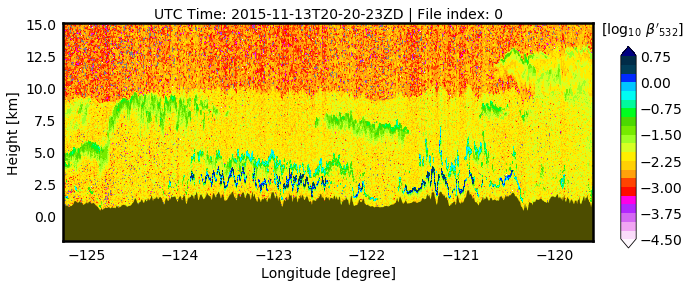

In [6]:
lev = np.arange(-4.5, 1.0, 0.25)
for num, name in enumerate(CALIPSO_daytime[:1]):
    key = basename(name)[26:-4]
    # read HDF4
    hdf4_obj = SD.SD(name, SD.SDC.READ)
    y = hdf4_obj.select('Latitude')[:, 0]
    x = hdf4_obj.select('Longitude')[:, 0]
    # indices inside the domain
    inds = BC_polygon.contains_points(list(zip(x, y)))
    lon_temp = x[inds]; lat_temp = y[inds]
    # detect breaking points
    if np.abs(np.diff(lon_temp)).max() > 10*(np.abs(lon_temp[1] - lon_temp[0])):
        ind = np.argmin(np.diff(lon_temp))
    else:
        ind = np.nan
    # import variables
    elev_temp = hdf4_obj.select('Surface_Elevation')[:, 0][inds]
    Beta532 = hdf4_obj.select('Total_Attenuated_Backscatter_532')[:][inds, :]
    hdf4_obj.end()
    # post-processing Beta
    Beta_temp = np.copy(Beta532) # copy since Beta532 will be used later
    Beta_temp[Beta_temp<0] = np.nan
    Beta_log10 = np.log10(Beta_temp)
    # Plotting
    title = ('UTC Time: '+key+' | File index: {}').format(num)
    Clib.CALIPSO_plot(z, lon_temp, elev_temp, Beta_log10, ind, lev, title)

The figure above is an example of the lidar profile with good quality. Near-surface high backscatter signal well follows the mountainous terrain. In the mid and upper troposphere, other weaker signals can also be found.

## CBL height retrieval

There are three different methods for retrieving the CBL height from downward lidar backscatter observations: (1) maximum gradient method [Melfi et al., 1985], (2) wavelet transform [Davis et al., 2000], and (3) maximum variance method [Jordan et al, 2010].

In this study, maximum variance method is applied, since it is more robust on handling the spotted missing data. The other two methods, especially the maximum gradient method, have grid-to-grid calculation which spreads the noise and leads to a poor performance.

Maximum variance method is based on the assumption that the daytime PBL top has a high lidar backscatter signal due to either the aerosol swelling or the cloud formation with increased humidity. During the retrieval, standard deviation of CALIPSO's attenuated backscatter profile was calculated with a moving window, missing values inside the window are ignored. After the calculation, for each vertical scatter profile, the mean value of the top 1% data is compared with the rest, if the ratio higher than a threshold and the maximum of the standard deviation is higher than a threshold, then the height of the maximum standard deviation is the height of the daytime PBL top.

In the following sections, an example of the retrievals is shown for illustration, and the batch processing code is provided. 

Reference

Melfi, S. H., Spinhirne, J. D., Chou, S. H., & Palm, S. P. (1985). Lidar observations of vertically organized convection in the planetary boundary layer over the ocean. *J. Clim. Appl. Meteorol.*, 24(8), 806-821.

Davis, K. J., Gamage, N., Hagelberg, C. R., Kiemle, C., Lenschow, D. H., & Sullivan, P. P. (2000). An objective method for deriving atmospheric structure from airborne lidar observations. *J. Atmos. Oceanic Technol.*, 17(11), 1455-1468.

Jordan, N. S., Hoff, R. M., & Bacmeister, J. T. (2010). Validation of Goddard Earth Observing System‐version 5 MERRA planetary boundary layer heights using CALIPSO. *J. Geophys. Res.*: Atmospheres, 115(D24).

### Experiments on a single file

This section explains the technical steps of the CBL height retrieval. `scipy.ndimage.filters.generic_filter` is used for calculating the standard deviation with a moving window. `generic_filter` runs a user defined function on a multi-dimensional image. Here the function `numpy.nanstd` is used as the given function, and the size of the window is three-by-three.

In [8]:
from scipy.ndimage.filters import generic_filter
ws = 3 # window size
std_temp = generic_filter(Beta532, np.nanstd, size=ws)
std_temp[std_temp>1e3] = np.nan # too big = noise or artificial
zgrid, xgrid = Clib.height_lon_grid(z, lon_temp, elev_temp)

The figure below shows the calculation of moving standard deviation on a given CALIPSO 532-nm total attenuated backscatter footprint. Several peaks can be found from the near-surface to the 8-km height atmosphere. Three profiles were chosen to show the physical meaning of these standard deviation peaks (example a-c) of which the peak with the lowest height and height value is the one that represents the PBL height. Also noted that, the PBL height signal may not be found in a noisy profile (example c).

Text(0.002,-1.25,'Surface return')

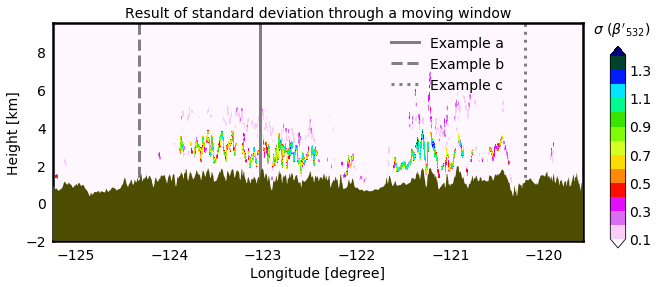

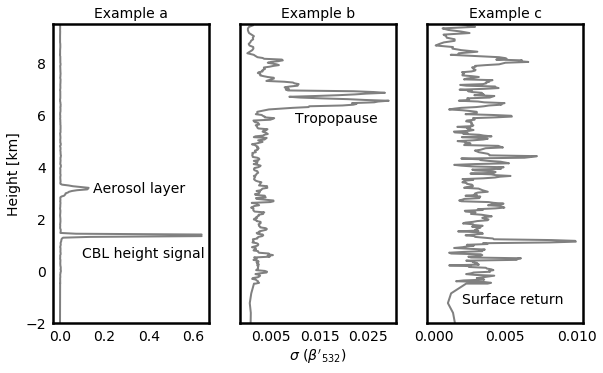

In [9]:
lev_std = np.arange(0.1, 1.5, 0.1)
ind_a = 2500; ind_b = -500; ind_c = 500
land_c = [0.3, 0.3, 0]
# Figure 1, location of transects
fig = plt.figure(figsize=(9.5, 4)); 
ax = fig.gca(); ax.grid(False); ax.set_ylim([-2, 9.5])
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14); ax.yaxis.set_tick_params(labelsize=14)
ax.tick_params(axis="both", which="both", bottom="off", top="off", \
       labelbottom="on", left="off", right="off", labelleft="on")
ax.set_title('Result of standard deviation through a moving window', fontsize=14)
ax.set_xlabel('Longitude [degree]', fontsize=14)
ax.set_ylabel('Height [km]', fontsize=14)
CS = ax.contourf(xgrid, zgrid, std_temp, lev_std, cmap=plt.cm.gist_ncar_r, extend='both')
ax.fill_between(lon_temp, elev_temp, -2, where=elev_temp>=-2, lw=0.0, \
                    facecolor=land_c, interpolate=True, zorder=4)
ax.axvline(x=lon_temp[ind_a], lw=3.0, color='gray', label='Example a')
ax.axvline(x=lon_temp[ind_b], lw=3.0, color='gray', ls='--', label='Example b')
ax.axvline(x=lon_temp[ind_c], lw=3.0, color='gray', ls=':', label='Example c')
LG = ax.legend(bbox_to_anchor=(0.875, 1), prop={'size':14}); LG.draw_frame(False)
cax = fig.add_axes([0.94, 0.1, 0.0225, 0.7])
CBar = fig.colorbar(CS, cax=cax, orientation='vertical')
CBar.ax.tick_params(axis='y', length=0, direction='in', labelsize=14)
CBar.ax.xaxis.set_label_position('top')
CBar.set_label(r"$\sigma\ \left(\beta'_{532}\right)$", y=1.125, labelpad=-30, rotation=360, fontsize=14)
# Figure 2, profiles
fig, AX = plt.subplots(1, 3, figsize=(9.5, 5.5));
AX = AX.flat
for ax in AX:
    ax.grid(False); ax.set_ylim([-2, 9.5])
    [i.set_linewidth(2.5) for i in ax.spines.values()]
    ax.xaxis.set_tick_params(labelsize=14); ax.yaxis.set_tick_params(labelsize=14)
    ax.tick_params(axis="both", which="both", bottom="off", top="off", \
       labelbottom="on", left="off", right="off", labelleft="off")
AX[0].tick_params(labelleft="on")
AX[0].set_xticks(np.arange(0.0, 0.8, 0.2)); AX[0].set_title('Example a', fontsize=14)
AX[1].set_xticks(np.arange(0.005, 0.04, 0.01)); AX[1].set_title('Example b', fontsize=14)
AX[2].set_xticks(np.arange(0, 0.015, 0.005)); AX[2].set_title('Example c', fontsize=14)
AX[1].set_xlabel(r"$\sigma\ \left(\beta'_{532}\right)$", fontsize=14)
AX[0].set_ylabel('Height [km]', fontsize=14)
AX[0].plot(std_temp[ind_a, :], z, '-', lw=2, color='gray')
AX[1].plot(std_temp[ind_b, :], z, '-', lw=2, color='gray')
AX[2].plot(std_temp[ind_c, :], z, '-', lw=2, color='gray')
AX[0].text(0.1, 0.5, 'CBL height signal', fontsize=14);
AX[0].text(0.15, 3, 'Aerosol layer', fontsize=14);
AX[1].text(0.01, 5.7, 'Tropopause', fontsize=14);
AX[2].text(0.002, -1.25, 'Surface return', fontsize=14)

Based on the example of profiles above, the two threshold for the top 1% vs the rest ratio and the maximum standard deviation were chosen as 5 and 0.45. The retrieval function in the `CALIPSO.py` and the CBL height retrieval result are shown below: 

```python
def CBL_Retrieval(std_temp, z, elev, ratio_thres=5, val_thres=0.5):
    '''
    Retreving CBL height through maximum variance method 
    '''
    CBL_H = np.zeros(len(std_temp))*np.nan
    for i in range(len(std_temp)):
        temp = std_temp[i, :]
        L = len(temp); top = -1*int(0.01*L)
        top_ind = np.argpartition(temp, top)[top:]
        top_flag = np.in1d(range(len(temp)), top_ind)
        ratio = np.nanmean(temp[top_flag])/np.nanmean(temp[~top_flag])
        if ratio > ratio_thres and np.nanmax(temp) > val_thres:
            CBL_H[i] = z[np.nanargmax(temp)]+elev[i]
        else:
            CBL_H[i] = np.nan
    return CBL_H
```

In [10]:
CBL_H = Clib.CBL_Retrieval(std_temp, z, elev_temp, ratio_thres=5, val_thres=0.45)

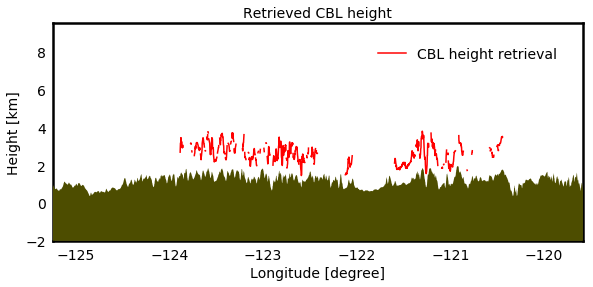

In [11]:
fig = plt.figure(figsize=(9.5, 4)); 
ax = fig.gca(); ax.grid(False) 
ax.set_ylim([-2, 9.5]); ax.set_xlim([lon_temp.min(), lon_temp.max()])
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.xaxis.set_tick_params(labelsize=14); ax.yaxis.set_tick_params(labelsize=14)
ax.tick_params(axis="both", which="both", bottom="off", top="off", \
       labelbottom="on", left="off", right="off", labelleft="on")
ax.set_title('Retrieved CBL height', fontsize=14)
ax.set_xlabel('Longitude [degree]', fontsize=14)
ax.set_ylabel('Height [km]', fontsize=14)
#CS = ax.contourf(xgrid, zgrid, std_temp, lev_std, cmap=plt.cm.gist_ncar_r, extend='both')
ax.fill_between(lon_temp, elev_temp, -2, where=elev_temp>=-2, lw=0.0, \
                    facecolor=land_c, interpolate=True, zorder=4)
ax.plot(lon_temp, CBL_H, 'r-', label='CBL height retrieval')
LG = ax.legend(bbox_to_anchor=(0.975, 0.95), prop={'size':14}); LG.draw_frame(False)

### Processing all the files and save as netCDF4

The CBL height retrieval algorithm is then repeated for multiple CALIPSO footprints, before the run, data with good quality and shows clear CBL height signals is selected. The retrievals are saved in in netCDF4 format, each footprint with lat/lon coordinate, elevation, time, original backscatter values, moving standard deviation values and CBL heights is stored in one group.

```python
# this part of code is not expected to have repeated runs
import netCDF4 as nc
ws = 3 # window size
cut = 175 # cut data above 15 km
# Initializing an netCDF4 file
nc_obj = nc.Dataset('../_data/ATSC-500/CALIPSO_CBL_Retrieval.nc', 'w', format='NETCDF4') 
nc_obj.description = 'CALIPSO daytime 532-nm TAB and Retrieved CBL height. For ATSC-500 Proj. YS'
group_keys = []
for name in np.array(CALIPSO_daytime):
    print(name)
    # dict keys
    key = basename(name)[26:-4]; group_keys.append(key)
    # import variables
    hdf4_obj = SD.SD(name, SD.SDC.READ)
    y = hdf4_obj.select('Latitude')[:, 0]
    x = hdf4_obj.select('Longitude')[:, 0]
    inds = BC_polygon.contains_points(list(zip(x, y)))
    lon = x[inds]; lat = y[inds]
    # If the footprint lonitude has a "jump"
    diff_lon = np.abs(np.diff(lon))
    if diff_lon.max() > 10*np.abs(lon[1] - lon[0]):
        ind_break = np.argmax(diff_lon)
    else:
        ind_break = 0
    # import HDF variables
    zT = hdf4_obj.select('Tropopause_Height')[:, 0][inds]
    time = hdf4_obj.select('Profile_UTC_Time')[:, 0][inds]
    elev = hdf4_obj.select('Surface_Elevation')[:, 0][inds]
    Beta532 = hdf4_obj.select('Total_Attenuated_Backscatter_532')[:][inds, cut:]
    hdf4_obj.end()
    # maximum variance based retrieval (by image filtering)
    Beta_std = generic_filter(Beta532, np.nanstd, size=ws)
    Beta_std[Beta_std>1e3] = np.nan
    CBL_H = CBL_Retrieval(Beta_std, z[cut:], elev, ratio_thres=5, val_thres=0.5)
    # set-up group, create netCDF4 dimensions
    temp_group = nc_obj.createGroup(key)
    temp_group.createDimension('S', 1)
    temp_group.createDimension('X', len(lon))
    temp_group.createDimension('H', len(z[cut:]))
    # create netCDF4 vars inside the group
    bp_nc = temp_group.createVariable('bp', np.int, ('S',), zlib=True)
    zT_nc = temp_group.createVariable('zT', np.float64, ('X',), zlib=True)
    CBL_nc = temp_group.createVariable('CBL_H', np.float64, ('X',), zlib=True)
    lat_nc = temp_group.createVariable('Latitude', np.float64, ('X',), zlib=True)
    lon_nc = temp_group.createVariable('Longitude', np.float64, ('X',), zlib=True)
    time_nc = temp_group.createVariable('Time_UTC', np.float64, ('X',), zlib=True)
    elev_nc = temp_group.createVariable('Elevation', np.float64, ('X',), zlib=True)
    Beta532_nc = temp_group.createVariable('TAB532', np.float64, ('X','H'), zlib=True)
    Beta_std_nc = temp_group.createVariable('TAB_std', np.float64, ('X','H'), zlib=True)
    # fill vars with arrays
    zT_nc[:] = zT
    bp_nc[:] = ind_break
    lat_nc[:] = lat; lon_nc[:] = lon
    CBL_nc[:] = CBL_H; time_nc[:] = time; elev_nc[:] = elev
    Beta532_nc[:] = Beta532; Beta_std_nc[:] = Beta_std
# save group keys
nc_obj.createDimension('keyLen', len(group_keys))
gpkeys_nc = nc_obj.createVariable('group_keys', '<U21', ('keyLen',))
gpkeys_nc[:] = np.array(group_keys)
# save z coord
nc_obj.createDimension('H', len(z[cut:]))
z_nc = nc_obj.createVariable('z', np.float64, ('H',))
z_nc[:] = z[cut:]
# write up complete
nc_obj.close()
```